In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from utility import calculate_input_gradients, perturb_inputs, preprocess_images, \
                    postprocess_features, save_data_hdf5,get_dataset_hdf5,\
                    build_one_class_svm, combine_inliners_outliers, apply_temp_scale_to_model,\
                    apply_log_temp_scale_to_model, perturb_inputs_odin, extract_layer_features

from utility_db_outliers import load_dataset
from models_lib import load_custom_model_for_ds
import h5py
from metrics import *
from general_setting import *
import time
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
#------------
from utility_methods import *
#this is necessary in TF 2.0 to run k.function for MC_Droupout.
tf.compat.v1.disable_eager_execution()

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
SCORE_LOC ="./scores/" #The folder in which calculated features are saved.

In [4]:
BATCH_SIZE = 1000
SAVE_RESULTS = True
id_name=ID_DS_LIST[0] # selects the ID dataset.
id_model=ID_MODEL_LIST[0]  # select the deep model used for training ID dataset.
print(id_name,id_model)

MNIST CUSTOM-MNIST


In [5]:
#layer_inx specifies the index of the OODL found by "find_oodl" jupyter file.
if id_name=="MNIST" and id_model=="CUSTOM-MNIST":
    layer_inx = 1
    OOD_DS_LIST       = OOD_DS_LIST_MNIST
    REM_TOP_LAYER=-1
    NUM_CLASS=10
    #**********************************************************
elif id_name=="CIFAR10":
    OOD_DS_LIST      = OOD_DS_LIST_CIFAR10
    NUM_CLASS=10
    if id_model=="VGG16":
        layer_inx = 5
        REM_TOP_LAYER=-2
    elif id_model=="ResNet-V1":
        layer_inx = 13
        REM_TOP_LAYER=-1
    elif id_model=="ResNet-V1-44":
        layer_inx = 48
        REM_TOP_LAYER=-1
    elif id_model=="DenseNet-40-12":
        REM_TOP_LAYER=-1
    #**********************************************************
elif id_name=="CIFAR100":
    OOD_DS_LIST      = OOD_DS_LIST_CIFAR100
    NUM_CLASS = 100
    if id_model=="VGG16":
        layer_inx = 3
        REM_TOP_LAYER=-2
    elif id_model=="ResNet-V1-44":
        layer_inx = 34
        REM_TOP_LAYER=-1

In [6]:
ood_appr_name = OOD_APPROACHES[0] # selects the OOD detection approach.
print("ID dataset:", id_name)
print("Model: ", id_model)
print("OOD approach name:",ood_appr_name )

ID dataset: MNIST
Model:  CUSTOM-MNIST
OOD approach name: ours


In [7]:
org_model = load_custom_model_for_ds(id_name, id_model)
# org_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
The weights of CUSTOM-MNIST model was loaded.


In [8]:
(org_traing_data, org_training_labels),(id_eva_data,_)  = load_dataset(id_name)

org_traing_data_processed = preprocess_images(id_name, org_traing_data, id_model, verbose=True)
id_eva_data_processed     = preprocess_images(id_name, id_eva_data, id_model, verbose=True)

Preprocessing is not needed.
Preprocessing is not needed.


In [9]:
def prepare_models(in_org_model, in_ood_appr_name):
    f_model=None
    f_grad_graph = None
    f_osvm = None
    f_ss = None
    if in_ood_appr_name in ("softmax", "entropy", "margin", "mc_dropout","mutual_info" ):
        f_model = in_org_model
        
    elif in_ood_appr_name=="odin_wo_p":
        scaled_model = apply_temp_scale_to_model(in_org_model, REM_TOP_LAYER)
        f_model = (scaled_model,)
        
    elif in_ood_appr_name=="odin_w_p":
        scaled_model = apply_temp_scale_to_model(in_org_model, REM_TOP_LAYER)
        scaled_log_model = apply_log_temp_scale_to_model(in_org_model, REM_TOP_LAYER, t_value=1000)
        grads = calculate_input_gradients(scaled_log_model)
        f_model = (scaled_model, grads, scaled_log_model )
        
    elif in_ood_appr_name=="mah_dist_logits" or in_ood_appr_name=="mah_dist_logits_w_p":
        tmp_m     = in_org_model.layers[REM_TOP_LAYER].input
        feature_model = Model(inputs=in_org_model.input, outputs=[tmp_m]) 
        sample_class_mean, sigma_inverse =  cal_mah_dist_parameters(feature_model, NUM_CLASS,
                                                                    org_traing_data_processed, org_training_labels)
        m_model = get_inference_mah_model(in_org_model, feature_model, sample_class_mean, sigma_inverse, NUM_CLASS)
        if in_ood_appr_name=="mah_dist_logits": 
            f_model=m_model
        elif in_ood_appr_name=="mah_dist_logits_w_p":
            grads = calculate_input_gradients(m_model)
            f_model=(m_model, grads)
            
    elif in_ood_appr_name=="ours" or in_ood_appr_name=="ours_w_p":
        tmp_l=in_org_model.layers[layer_inx]
        feature_model = Model(inputs=in_org_model.input, outputs=tmp_l.output)

        features = extract_layer_features(feature_model,org_traing_data_processed,layer_inx,BATCH_SIZE,\
                                          shorten_model=True )
        osvm, ss = build_one_class_svm(features)
        
        if in_ood_appr_name=="ours":
            f_model = (feature_model, osvm, ss)
        elif in_ood_appr_name=="ours_w_p": 
            scaled_log_model = apply_log_temp_scale_to_model(in_org_model, REM_TOP_LAYER, t_value=1)
            grads=calculate_input_gradients(scaled_log_model)
            f_model = (feature_model,grads, osvm, ss)
        
    return f_model

In [10]:
def detect_OOD_inputs(in_org_model, in_model, in_ood_appr_name,in_mix_id_odd, in_extra_data):
    if in_ood_appr_name=="softmax":
        scores = detect_ood_softmax(in_org_model, in_model, in_mix_id_odd)
    elif in_ood_appr_name=="odin_wo_p":
        scores = detect_ood_odin(in_org_model, in_model, in_mix_id_odd, in_extra_data, input_preprocessing=False)
    elif in_ood_appr_name=="odin_w_p":
        scores = detect_ood_odin(in_org_model, in_model, in_mix_id_odd, in_extra_data, input_preprocessing=True)
    elif in_ood_appr_name=="mah_dist_logits":
        scores = detect_mah_dist(in_org_model, in_model, in_mix_id_odd,  in_extra_data, NUM_CLASS,
                                                                                             input_preprocessing=False)
    elif in_ood_appr_name=="mah_dist_logits_w_p":
        scores = detect_mah_dist(in_org_model, in_model, in_mix_id_odd,  in_extra_data, NUM_CLASS,
                                                                                             input_preprocessing=True)
    elif in_ood_appr_name=="entropy":
        scores = detect_entropy(in_org_model, in_model, in_mix_id_odd)
    elif in_ood_appr_name=="margin":
        scores = detect_margin(in_org_model, in_model, in_mix_id_odd)
    elif in_ood_appr_name== "mc_dropout":
        scores = detect_mc_dropout(in_org_model, in_model, in_mix_id_odd)
    elif in_ood_appr_name== "mutual_info":
        scores = detect_mutual_info(in_org_model, in_model, in_mix_id_odd)
    elif in_ood_appr_name=="ours":
        scores = detect_ood_svm(in_org_model, in_model, in_mix_id_odd,  in_extra_data, input_preprocessing=False)
    elif in_ood_appr_name=="ours_w_p":
        scores = detect_ood_svm(in_org_model, in_model, in_mix_id_odd,  in_extra_data, input_preprocessing=True)

    return scores

In [11]:
detect_model= prepare_models(org_model,ood_appr_name)

Preprocessing is not needed.


<Figure size 432x288 with 0 Axes>

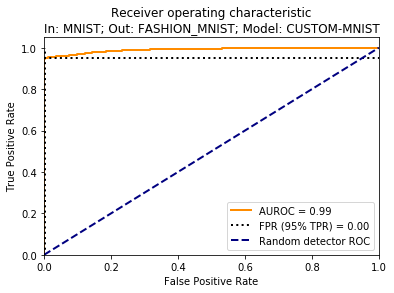

{'fpr_at_95_tpr': 0.42, 'detection_error': 2.7050000000000023, 'auroc': 99.044857, 'aupr_out': 98.7835368140499, 'aupr_in': 99.2664499023909}
results was saved.
Preprocessing is not needed.


<Figure size 432x288 with 0 Axes>

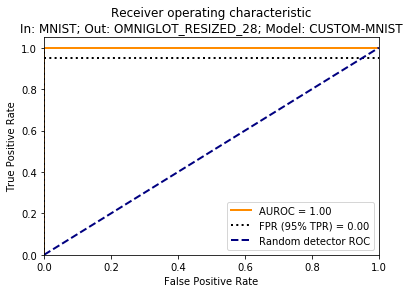

{'fpr_at_95_tpr': 0.0, 'detection_error': 0.0, 'auroc': 100.0, 'aupr_out': 100.0, 'aupr_in': 100.0}
results was saved.
Preprocessing is not needed.


<Figure size 432x288 with 0 Axes>

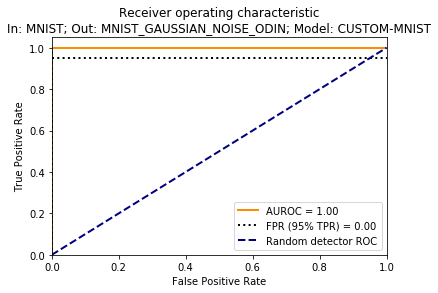

{'fpr_at_95_tpr': 0.0, 'detection_error': 0.0, 'auroc': 100.0, 'aupr_out': 100.0, 'aupr_in': 100.0}
results was saved.
Preprocessing is not needed.


<Figure size 432x288 with 0 Axes>

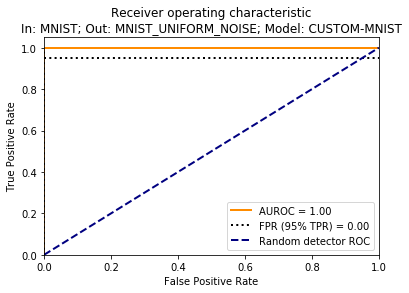

{'fpr_at_95_tpr': 0.0, 'detection_error': 0.0, 'auroc': 100.0, 'aupr_out': 100.0, 'aupr_in': 100.0}
results was saved.


In [12]:
SCORE_LOC = SCORE_LOC+ood_appr_name+"/"
for i, ood_ds_name in enumerate(OOD_DS_LIST):
    (_,_),(ood_eva_data,_) = load_dataset(ood_ds_name)
    ood_eva_data_processed    = preprocess_images(id_name, ood_eva_data, id_model, verbose=True)
    mixed_data, mixed_labels = combine_inliners_outliers(id_eva_data_processed,ood_eva_data_processed)
    
    if ood_appr_name in ("ours_w_p", "odin_w_p", "mah_dist_logits_w_p"):
        extra_data = (get_pert_magnitude(ood_appr_name, org_model, detect_model, id_eva_data_processed,\
                                                                            ood_eva_data_processed, NUM_CLASS ) ,)
    else:
        extra_data=None

    scores = detect_OOD_inputs(org_model, detect_model, ood_appr_name, mixed_data, extra_data)
    title = "Receiver operating characteristic"
    title = title+"\nIn: "+id_name+"; Out: "+ ood_ds_name+"; Model: "+ id_model
    plt.figure(i)
    plt_img = plot_roc(scores, mixed_labels,title)
    print(get_summary_statistics(scores, mixed_labels))
    
    if SAVE_RESULTS:
        
        if not os.path.isdir(SCORE_LOC): os.makedirs(SCORE_LOC)
        file_address = SCORE_LOC+id_name+"_"+id_model+"_"+ood_ds_name
        if ood_appr_name=="ours" or ood_appr_name=="ours_w_p":
            save_data_hdf5(scores, "scores_"+str(layer_inx) ,file_address , "a" )
            save_data_hdf5(mixed_labels, "labels_"+str(layer_inx) ,file_address , "a" )
        else:
            save_data_hdf5(scores, "scores" ,file_address , "a" )
            save_data_hdf5(mixed_labels, "labels" ,file_address , "a" )
        print("results was saved.")
    